In [2]:
import cv2
import torch
import os

print(f"cv2 cuda devices {cv2.cuda.getCudaEnabledDeviceCount()}")

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

print(f"Torch using {DEVICE}")

os.chdir('/home/nick/OSMLoc')
print(os.getcwd())

cv2 cuda devices 1
Torch using cuda
/home/nick/OSMLoc


In [8]:


from maploc.models.depth_anything.dpt import DepthAnything

# Configuration for DepthAnything model - based on osmloc configuration
config = {
    'encoder': 'vitl',           # encoder type: 'vits', 'vitb', or 'vitl'
    'features': 256,            # feature dimension
    'out_dim': 128,             # output dimension
    'out_channels': [256, 512, 1024, 1024],  # output channels for each layer
    # 'ckpt': 'maploc/models/depth_anything/ckpt/depth_anything_vitl14.pth',  # checkpoint path
    'use_bn': False,            # use batch normalization
    'use_clstoken': False,      # use class token
    'localhub': True,           # load DINOv2 from local hub
    'size': [518, 518],        # input size
    'val': False               # validation mode
}

# Create the model with the proper configuration
# The DepthAnything class expects the config dict and will unpack it

# model = DepthAnything.from_pretrained("LiheYoung/depth_anything_{:}14".format(config.encoder))
# Create the model with debugging to check weight loading
model = DepthAnything(config)

# Check if weights were loaded properly
print(f"Model created. Checking weight loading...")
try:
    depth_conv_weight = model.depth_head.scratch.output_conv2[1].weight
    print(f"Depth head output conv weight mean: {depth_conv_weight.mean().item():.6f}")
    print(f"Depth head output conv weight std: {depth_conv_weight.std().item():.6f}")
except Exception as e:
    print(f"Error checking weights: {e}")
    # Try alternative weight checking
    try:
        for name, param in model.named_parameters():
            if 'depth' in name.lower() and param.dim() > 1:
                print(f"Weight {name} - mean: {param.mean().item():.6f}, std: {param.std().item():.6f}")
                break
    except Exception as e2:
        print(f"Alternative weight check also failed: {e2}")

model = model.to(DEVICE).eval()

print(f"Loaded Model on {DEVICE}")

# Additional check: verify checkpoint was loaded by checking if weights are non-zero
total_params = sum(p.numel() for p in model.parameters())
non_zero_params = sum((p != 0).sum().item() for p in model.parameters())
print(f"Total parameters: {total_params:,}, Non-zero parameters: {non_zero_params:,}")
print(f"Percentage of non-zero weights: {100 * non_zero_params / total_params:.2f}%" if total_params > 0 else "No parameters found")


# Convert image to tensor and normalize
from torchvision.transforms import Compose
from maploc.models.depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

image = cv2.cvtColor(cv2.imread('../Data/IMG_20250327_105752435_HDR.jpg'), cv2.COLOR_BGR2RGB) / 255.0
image = transform({'image': image})['image']
# Debug input tensor
image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)
print(f"Input tensor shape: {image.shape}, device: {image.device}")
print(f"Input tensor stats - min: {image.min().item():.4f}, max: {image.max().item():.4f}, mean: {image.mean().item():.4f}")

# Forward pass with detailed debugging
print("Starting forward pass...")
with torch.no_grad():
    output = model(image)
    



vitl
Model created. Checking weight loading...
Error checking weights: 'ReLU' object has no attribute 'weight'
Weight depth_head.projects.0.weight - mean: -0.000048, std: 0.018037
Loaded Model on cuda
Total parameters: 336,875,201, Non-zero parameters: 336,601,519
Percentage of non-zero weights: 99.92%
Input tensor shape: torch.Size([1, 3, 518, 686]), device: cuda:0
Input tensor stats - min: -2.5030, max: 3.0917, mean: 0.0715
Starting forward pass...


Got Depth map with shape: (518, 686)
Depth stats - min: 0.0000, max: 0.0000, mean: 0.0000
Before normalization - min: 0.0000, max: 0.0000
After normalization - min: 0, max: 0
Saved depth map to depth.png


(-0.5, 685.5, 517.5, -0.5)

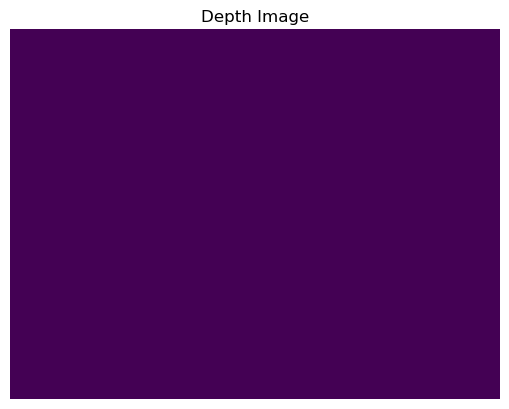

In [9]:

import matplotlib.pyplot as plt

# Remove batch dimension and squeeze to get 2D array
depth = output["simple"].cpu().detach().numpy().squeeze()  # This removes the batch dimension

print(f"Got Depth map with shape: {depth.shape}")
print(f"Depth stats - min: {depth.min():.4f}, max: {depth.max():.4f}, mean: {depth.mean():.4f}")

# Debug: check depth values before normalization
print(f"Before normalization - min: {depth.min():.4f}, max: {depth.max():.4f}")
depth_normalized = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print(f"After normalization - min: {depth_normalized.min()}, max: {depth_normalized.max()}")

# Save depth map
cv2.imwrite('depth.png', depth_normalized)
print(f"Saved depth map to depth.png")


plt.imshow(depth_normalized)
plt.title("Depth Image")
plt.axis('off')
